### Guided Practice: Logit Function and Odds

In [1]:
import math
math.exp(1)

2.718281828459045

math.exp(1)

In [8]:
import math
def logit_func(odds):
    return map(lambda x: math.log(x),odds)

def sigmoid_func(logit):
    return map(lambda x: 1/(1 + math.exp(-x)),logit)
    

odds_set = [
    5./1,
    20./1,
    1.1/1,
    1.8/1,
    1.6/1
]

print sigmoid_func(logit_func(odds_set))

[0.8333333333333334, 0.9523809523809523, 0.5238095238095238, 0.6428571428571428, 0.6153846153846154]


In [3]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

In [4]:
lm = LogisticRegression()

df = pd.read_csv('../../assets/dataset/collegeadmissions.csv')

In [5]:
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [6]:
df = df.join(pd.get_dummies(df['rank']))

In [11]:
df.head()

,admit,gre,gpa,rank,1,2,3,4
0,0,380,3.61,3,0,0,1,0
1,1,660,3.67,3,0,0,1,0
2,1,800,4.00,1,1,0,0,0
3,1,640,3.19,4,0,0,0,1
4,0,520,2.93,4,0,0,0,1


In [7]:
lm.fit(df[['gre', 'gpa', 1, 2, 3,]], df['admit'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Building a model with regularization using KFold and GridSearchCV

In [11]:
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV
import numpy as np

In [12]:
#Prepping the Cross Validation object
logistic_cv = KFold(n=len(df),n_folds = 5,shuffle = True)

#The main parameter to tune in a Logistic Regression is the C value where C = 1/alpha (alpha = regularization strength)
logistic_params = {'C': np.logspace(-10,10,21)}
logistic_estimator = LogisticRegression()

#Define the Grid Search Object

gs = GridSearchCV(estimator = logistic_estimator,param_grid = logistic_params,cv = logistic_cv)
gs.fit(df[['gre','gpa',1,2,3]],df['admit'])

GridSearchCV(cv=sklearn.cross_validation.KFold(n=400, n_folds=5, shuffle=True, random_state=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [17]:
lm = gs.best_estimator_ 
print lm.coef_
print lm.intercept_
print df.admit.mean()

[[ 0.00210453  0.65699186  1.45597263  0.79700131  0.14088979]]
[-4.86298045]
0.3175


In [35]:
gs.best_score_

0.70499999999999996

Below is some code to walk through confusion matrices. It'll be useful for working through the Titanic problem.

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,roc_curve, roc_auc_score

### Generate a confusion matrix on the training data

In [28]:
logistic_confusion = confusion_matrix(df['admit'],lm.predict(df[['gre', 'gpa', 1, 2, 3,]]))
logistic_confusion = pd.DataFrame(logistic_confusion,index = ['actual_0','actual_1'],columns = ['pred_0','pred_1'])
print logistic_confusion

          pred_0  pred_1
actual_0     256      17
actual_1      99      28


In [33]:
#Accuracy sanity-check
accuracy = float((logistic_confusion.loc['actual_0','pred_0'] + logistic_confusion.loc['actual_1','pred_1'])) / len(df)
print accuracy

#Does it match our best_score from gs?!? Yes!!

0.71


### Classification Metrics

**Accuracy**: Defined as total correct classification / total classification.

Accuracy isn't the ONLY metric. We ALSO care about what we got wrong because that may be COSTLY from a Business POV.

|          | Pred_0         | pred_1         |
|----------|----------------|----------------|
| Actual_0 | 256 (True Neg) | 17 (False Pos) |
| Actual_1 | 99 (False Neg) | 28 (True Pos)  |

#### Other Metrics

**False Positive Rate (FPR)** = $\frac{\text{False Positives}}{\text{False Positives} \hspace{2 mm}+\hspace{2mm} \text{True Negatives}}$

**True Positive Rate (TPR)** = $\frac{\text{True Positives}}{\text{True Positives} \hspace{2 mm}+\hspace{2mm} \text{False Negatives}}$

**Recall** = Same as TPR

**Precision** = $\frac{\text{True Positives}}{\text{True Positives} \hspace{2 mm}+\hspace{2mm} \text{False Positives}}$

### Question: What's the difference between TPR (or recall) and Precision?

In [46]:
#Calculate the metrics:

fpr = float(logistic_confusion.loc['actual_0','pred_1']) / (df['admit'] == 0).sum()
print 'fpr = %s' % fpr

tpr = float(logistic_confusion.loc['actual_1','pred_1']) / (df['admit'] == 1).sum()
print 'tpr = %s' % tpr

precision = float(logistic_confusion.loc['actual_1','pred_1']) / logistic_confusion['pred_1'].sum()
print 'precision = %s' % precision

fpr = 0.0622710622711
tpr = 0.220472440945
precision = 0.622222222222


### Question: How does the predict function predict?

If $P(Y=1|X) > .5$, predict Y = 1 otherwise predict 0.

Let's verify this manually:

In [65]:
probability_pred = lm.predict_proba(df[['gre','gpa',1,2,3]])[:,1]
predictions = (probability_pred >= .5) + 0   #The threshold is given by .5

(lm.predict(df[['gre','gpa',1,2,3]]) == predictions).sum()

400

#### The threshold was .5! What if we change that?

In [150]:
#If we want to be cautious about predictions
probability_pred = lm.predict_proba(df[['gre','gpa',1,2,3]])[:,1]
predictions = (probability_pred >= .8) + 0   #The threshold is given by .8

#Getting the confusion matrix
logistic_confusion = confusion_matrix(df['admit'],predictions)
logistic_confusion = pd.DataFrame(logistic_confusion,index = ['actual_0','actual_1'],columns = ['pred_0','pred_1'])
print logistic_confusion

          pred_0  pred_1
actual_0     273       0
actual_1     127       0


In [73]:
#Our friendly classification metrics

fpr = float(logistic_confusion.loc['actual_0','pred_1']) / (df['admit'] == 0).sum()
print 'fpr = %s' % fpr

tpr = float(logistic_confusion.loc['actual_1','pred_1']) / (df['admit'] == 1).sum()
print 'tpr = %s' % tpr

fpr = 0.0
tpr = 0.0


#### Does that make sense?

We were 'so' cautious about predictions that yes, we **minimized** our false positive rate (as a fraction of all the negatives, we didn't make any mistakes) but we also minimized our **true** positive rate (as a fraction of all the positives, we didn't classify anybody as positive)!

Example: Perhaps a judge that doesn't like the death penalty would always predict not-guilty in a bunch of cases involving capital punishments. The judge is being *conservative*

In [105]:
#If we want to be liberal predictions
probability_pred = lm.predict_proba(df[['gre','gpa',1,2,3]])[:,1]
predictions = (probability_pred >= 0.05) + 0   #The threshold is given by .8

#Getting the confusion matrix
logistic_confusion = confusion_matrix(df['admit'],predictions)
logistic_confusion = pd.DataFrame(logistic_confusion,index = ['actual_0','actual_1'],columns = ['pred_0','pred_1'])
print logistic_confusion

          pred_0  pred_1
actual_0       0     273
actual_1       0     127


In [77]:
#Our friendly classification metrics

fpr = float(logistic_confusion.loc['actual_0','pred_1']) / (df['admit'] == 0).sum()
print 'fpr = %s' % fpr

tpr = float(logistic_confusion.loc['actual_1','pred_1']) / (df['admit'] == 1).sum()
print 'tpr = %s' % tpr

fpr = 1.0
tpr = 1.0


#### Does that make sense?

We were 'so' liberal about predictions that yes, we **maximized** our true positive rate (as a fraction of all the positives, we didn't make any mistakes) but we also maximized our false positive rate (as a fraction of all the negatives, we didn't classify any correctly)!


### What if we did this for a BUNCH of different thresholds

In [111]:
threshold_range = np.arange(0,1,.001)
tpr = np.zeros(1000)
fpr = np.zeros(1000)

#Doing this outside to speed up for-loop
num_zeros = (df['admit'] == 0).sum()
num_ones = (df['admit'] == 1).sum()

for idx, threshold in enumerate(threshold_range):
    
    probability_pred = lm.predict_proba(df[['gre','gpa',1,2,3]])[:,1]
    predictions = (probability_pred >= threshold) + 0
    logistic_confusion = confusion_matrix(df['admit'],predictions)
    logistic_confusion = pd.DataFrame(logistic_confusion,index = ['actual_0','actual_1'],columns = ['pred_0','pred_1'])
    
    fpr[idx] = float(logistic_confusion.loc['actual_0','pred_1']) / num_zeros
    tpr[idx] = float(logistic_confusion.loc['actual_1','pred_1']) / num_ones


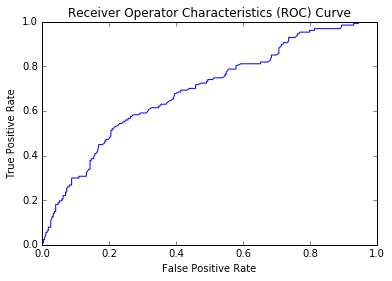

In [114]:
#Let's plot fpr and tpr as a scatterplot 
plt.plot(fpr,tpr)
plt.title('Receiver Operator Characteristics (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### What happens if our classifier was AMAZING?!

1. You would expect that for all actual **negatives**, our classifier spits out a probability ~ **0** (but not exactly 0)

2. You would expect that for all actual **positives**, our classifier spits out a probability ~ **1** (but not exactly 1)

When the threshold is **0** --> tpr = 1 , fpr = 1

When the threshold is **1** --> tpr = 0 , fpr = 0

When the threshold is **>0 ** --> tpr = 1 , fpr = 0

When the threshold is **<1** --> tpr = 1 , fpr = 0

**IN SUMMARY**

When the threshold is 0, the point on the ROC curve is (1,1). When the threshold is varied to be *just* below 1, the point on the ROC jumps to (0,1) and remains there until the threshold becomes 0 when the point on the ROC jumps again to (0,0)

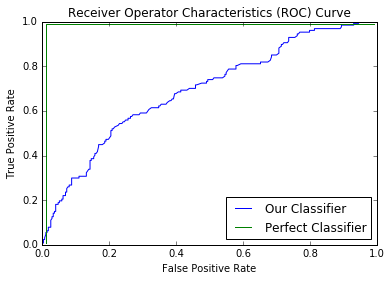

In [149]:
plt.plot(fpr,tpr,label = "Our Classifier")
plt.title('Receiver Operator Characteristics (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.plot([0.01,0.01,.99],[0.01,.99,.99],label="Perfect Classifier")

plt.legend(loc=4)

### How good is our classifier? How do we compare it to perfection?

Integrate the curves. That is find the Area Under Curve (AUC)!

In [134]:
import scipy as sc

print 'Perfect AUC is %s' % sc.trapz([0,1,1],[0,0,1])

Perfect AUC is 1.0


In [139]:
sc.trapz(tpr,fpr)

print 'Our AUC is %s' % -sc.trapz(tpr,fpr)

Our AUC is 0.691903896628


### Of course, Python can do ALL of this for you!

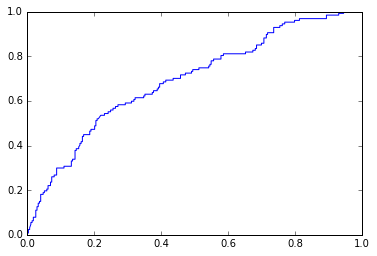

In [145]:
probas = lm.predict_proba(df[['gre','gpa',1,2,3]])
plt.plot(roc_curve(df[['admit']], probas[:,1])[0], roc_curve(df[['admit']], probas[:,1])[1])

In [148]:
print 'Our AUC score using sklearn is %s' % roc_auc_score(df['admit'], probas[:,1])

Our AUC score using sklearn is 0.691860632806


This differences are numerical roundoffs!

### Titanic Problem

** Goals **

1. Spend a few minutes determining which data would be most important to use in the prediction problem. You may need to create new features based on the data available. Consider using a feature selection aide in sklearn. But a worst case scenario; identify one or two strong features that would be useful to include in the model.
2. Spend 1-2 minutes considering which _metric_ makes the most sense to optimize. Accuracy? FPR or TPR? AUC? Given the business problem (understanding survival rate aboard the Titanic), why should you use this metric?
3. Build a tuned Logistic model. Be prepared to explain your design (including regularization), metric, and feature set in predicting survival using the tools necessary (such as a fit chart).